In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.layers import Input,Dense,Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel,preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys, os

In [3]:
# Data from: https://mmspg.epfl.ch/dowloads/food-image-datasets/
#!wget --passive-ftp --prefer-family=ipv4 --ftp-user FoodImage@grebvm2.epfl.ch \
# --ftp-password Cahclmoo -nc ftp://tremplin.epfl.ch/Food-5K.zip
!wget -nc https://archive.org/download/food-5-k/Food-5K.zip

--2025-02-28 17:33:13--  https://archive.org/download/food-5-k/Food-5K.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia801606.us.archive.org/13/items/food-5-k/Food-5K.zip [following]
--2025-02-28 17:33:14--  https://ia801606.us.archive.org/13/items/food-5-k/Food-5K.zip
Resolving ia801606.us.archive.org (ia801606.us.archive.org)... 207.241.228.126
Connecting to ia801606.us.archive.org (ia801606.us.archive.org)|207.241.228.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447001986 (426M) [application/zip]
Saving to: ‘Food-5K.zip’

Food-5K.zip         100%[===================>] 426.29M  7.04MB/s    in 17s     

2025-02-28 17:33:30 (25.7 MB/s) - ‘Food-5K.zip’ saved [447001986/447001986]



In [4]:
! unzip -qq -o Food-5K.zip

In [5]:
!ls

Food-5K  Food-5K.zip  __MACOSX	sample_data


In [6]:
!ls Food-5K

evaluation  training  validation


In [7]:
!mv Food-5K/* .

In [8]:
!ls training

0_0.jpg     0_1338.jpg	0_325.jpg  0_663.jpg  1_0.jpg	  1_1338.jpg  1_325.jpg  1_663.jpg
0_1000.jpg  0_1339.jpg	0_326.jpg  0_664.jpg  1_1000.jpg  1_1339.jpg  1_326.jpg  1_664.jpg
0_1001.jpg  0_133.jpg	0_327.jpg  0_665.jpg  1_1001.jpg  1_133.jpg   1_327.jpg  1_665.jpg
0_1002.jpg  0_1340.jpg	0_328.jpg  0_666.jpg  1_1002.jpg  1_1340.jpg  1_328.jpg  1_666.jpg
0_1003.jpg  0_1341.jpg	0_329.jpg  0_667.jpg  1_1003.jpg  1_1341.jpg  1_329.jpg  1_667.jpg
0_1004.jpg  0_1342.jpg	0_32.jpg   0_668.jpg  1_1004.jpg  1_1342.jpg  1_32.jpg	 1_668.jpg
0_1005.jpg  0_1343.jpg	0_330.jpg  0_669.jpg  1_1005.jpg  1_1343.jpg  1_330.jpg  1_669.jpg
0_1006.jpg  0_1344.jpg	0_331.jpg  0_66.jpg   1_1006.jpg  1_1344.jpg  1_331.jpg  1_66.jpg
0_1007.jpg  0_1345.jpg	0_332.jpg  0_670.jpg  1_1007.jpg  1_1345.jpg  1_332.jpg  1_670.jpg
0_1008.jpg  0_1346.jpg	0_333.jpg  0_671.jpg  1_1008.jpg  1_1346.jpg  1_333.jpg  1_671.jpg
0_1009.jpg  0_1347.jpg	0_334.jpg  0_672.jpg  1_1009.jpg  1_1347.jpg  1_334.jpg  1_672.jpg
0_100.jpg   0_1

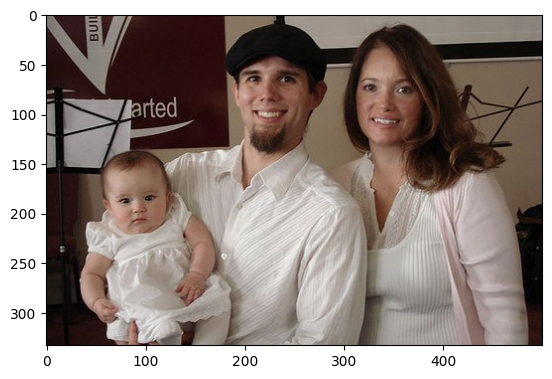

In [9]:
plt.imshow(image.load_img('training/0_100.jpg'))
plt.show()

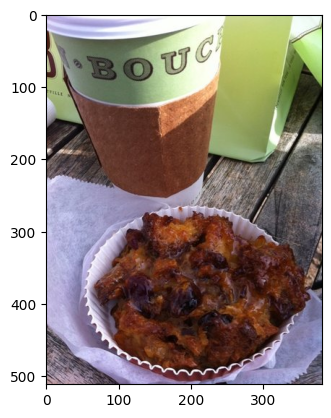

In [10]:
plt.imshow(image.load_img('training/1_100.jpg'))
plt.show()

In [11]:
!mkdir data

In [12]:
!mkdir data/train
!mkdir data/test
!mkdir data/train/nonfood
!mkdir data/train/food
!mkdir data/test/nonfood
!mkdir data/test/food

In [13]:
# Move the images
# Note we will consider 'training' to be the train set
#      'validation' folder will be the test set
#      ignore the 'evaluation' set
!mv training/0*.jpg data/train/nonfood
!mv training/1*.jpg data/train/food
!mv validation/0*.jpg data/test/nonfood
!mv validation/1*.jpg data/test/food

In [14]:
train_path = 'data/train'
valid_path = 'data/test'

In [15]:
IMAGE_SIZE =[200,200]

In [25]:
# useful for getting number of files
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')

In [26]:
# useful for getting number of classes
folders = glob(train_path + '/*')
folders

['data/train/food', 'data/train/nonfood']

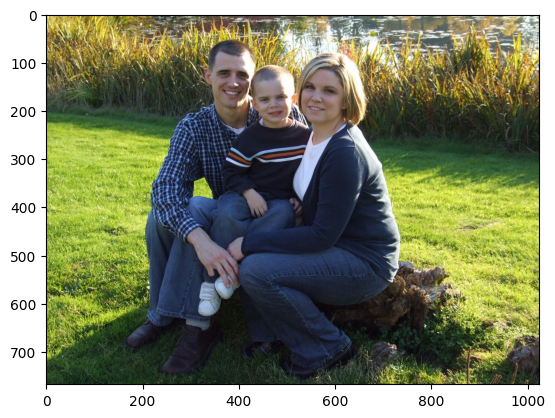

In [30]:
# look at an image for fun
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [16]:
batch_size = 128
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=IMAGE_SIZE,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    valid_path,
    image_size=IMAGE_SIZE,
    batch_size=batch_size
)

Found 3000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [17]:
# check the class names
class_names = train_ds.class_names
K = len(class_names)
print(class_names)

['food', 'nonfood']


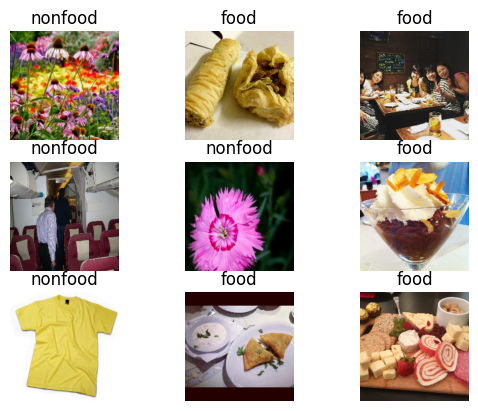

In [18]:
# visualize the data
for images, labels in train_ds.take(1):
  # takes one batch, but we'll only use 9 (3x3)
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [19]:
# apply preprocess_input
def preprocess(image,label):
  return preprocess_input(image),label

train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [21]:
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE+[3],
    weights='imagenet',
    include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [22]:
# map the data into feature vectors
x = Flatten()(ptm.output)

In [23]:
# create a model object
model = Model(inputs=ptm.input,outputs=x)

In [24]:
# view the structure of the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 200, 200, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 200, 200, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 100, 100, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 100, 100, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 100, 100, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 50, 50, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 50, 50, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 50, 50, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 50, 50, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 25, 25, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 25, 25, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 25, 25, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 25, 25, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
#Ntrain = len(image_files)
#Nvalid = len(valid_image_files)

## Figure out the output size
## The error is caused because you're trying to access IMAGE_SIZE[3] which is out of range
## IMAGE_SIZE only has 2 elements (index 0 and 1).
## You likely want to pass in the shape (1, 200, 200, 3) to create a random input image.
feat = model.predict(np.random.random([1] + IMAGE_SIZE + [3]))  # Change this line
#D = feat.shape[1]

#X_train = np.zeros((Ntrain, D))
#Y_train = np.zeros(Ntrain)
#X_valid = np.zeros((Nvalid, D))
#Y_valid = np.zeros(Nvalid)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [33]:
X_train = model.predict(train_ds)
X_valid = model.predict(val_ds)

24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step


In [34]:
# NOTE: tihs won't work if you shuffled the train set!
Y_train = np.concatenate([y for x, y in train_ds])
Y_valid = np.concatenate([y for x, y in val_ds])

In [37]:
X_train.shape , Y_train.shape , X_valid.shape , Y_valid.shape

((3000, 18432), (3000,), (1000, 18432), (1000,))

In [38]:
X_train.max(), X_train.min()

(597.7189, 0.0)

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train2 = scaler.fit_transform(X_train)
X_valid2 = scaler.transform(X_valid)

In [40]:
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression()
logr.fit(X_train2, Y_train)
print(logr.score(X_train2, Y_train))
print(logr.score(X_valid2, Y_valid))

1.0
0.982


In [41]:
# Do logistic regression in Tensorflow

i = Input(shape=(D,))
x = Dense(1, activation='sigmoid')(i)
linearmodel = Model(inputs=i, outputs=x)

In [43]:
linearmodel.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [44]:
r = linearmodel.fit(X_train2, Y_train,
                    validation_data=(X_valid2, Y_valid),
                    batch_size=128,
                    epochs=10)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.8536 - loss: 0.3150 - val_accuracy: 0.9780 - val_loss: 0.0551
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9942 - loss: 0.0172 - val_accuracy: 0.9760 - val_loss: 0.0497
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.9780 - val_loss: 0.0462
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9790 - val_loss: 0.0453
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.9790 - val_loss: 0.0451
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9790 - val_loss: 0.0450
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9790 - val_loss: 0.0451
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9800 - val

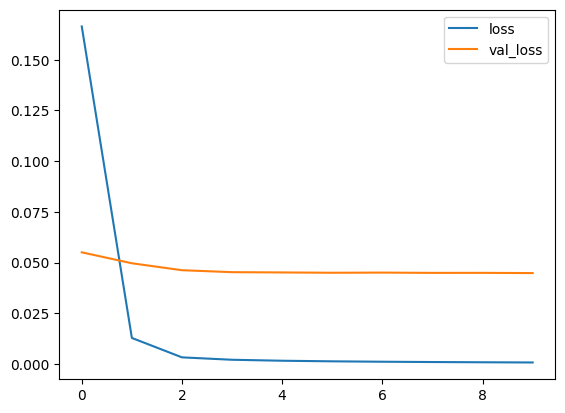

In [45]:
# loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

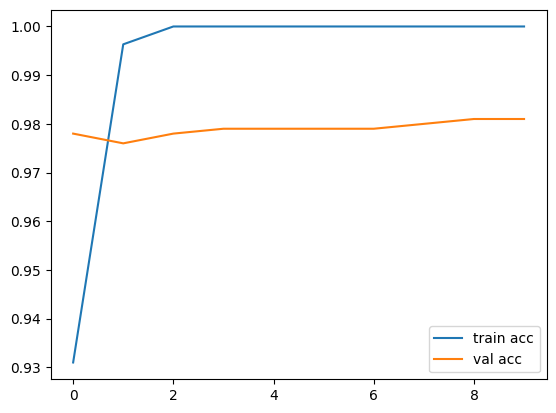

In [46]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [47]:
# Exercise: What happends if you ONLY  use a flat (vector input) neural network
# without transforming the data with the pretrainde model first?
